In [23]:
from toolkit import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from GridSearch import * 
from Visuals import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
import json

In [8]:
train_data=load_data(train=True)
test_data=load_data(train=False)

In [9]:
train_data=train_data.drop(columns=['transaction_id','timestamp','user_id','merchant_id', 
                        'signup_date','sex','geometry','continent_user', 'continent_merchant',
                         'continent_transaction','currency'],axis=1)
test_data=test_data.drop(columns=['transaction_id','timestamp','user_id','merchant_id', 
                        'signup_date','sex','geometry','continent_user', 'continent_merchant',
                         'continent_transaction','currency'],axis=1)

In [10]:
y_train=np.ravel(train_data[['is_fraud']])
df_train=train_data.drop(columns=['is_fraud'],axis=1)
y_test=np.ravel(test_data[['is_fraud']])
df_test=test_data.drop(columns=['is_fraud'],axis=1)

In [12]:
colTrans=make_preprocessor(df_train) 
X_train=colTrans.fit_transform(df_train)
X_test = colTrans.transform(df_test)

In [13]:
X_train.shape 

(400000, 239)

In [14]:
X_test.shape

(100000, 239)

In [15]:
feature_names_train = colTrans.get_feature_names_out(input_features=df_train.columns)

## Feature selection

In [13]:
rf_est = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=2,
    random_state=42, class_weight="balanced"
)
rf_est.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=400, n_jobs=2,
                       random_state=42)

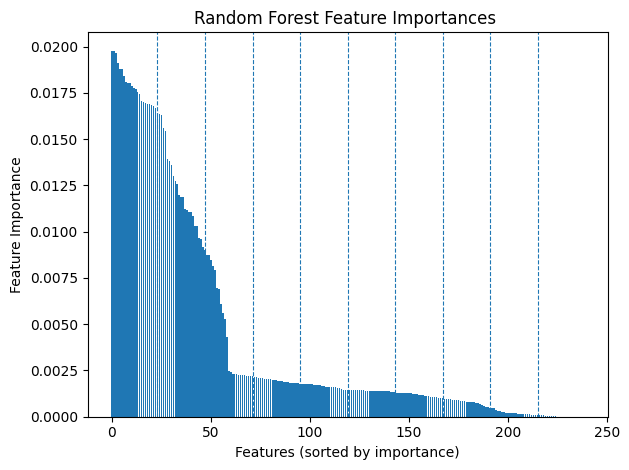

In [14]:
importances = rf_est.feature_importances_
indices     = np.argsort(importances)[::-1]
n_features  = len(importances)

decile_idxs = [int(n_features * q / 10) for q in range(1, 10)]

plt.figure()
plt.bar(range(n_features), importances[indices])

for idx in decile_idxs:
    plt.axvline(x=idx, linestyle='--', linewidth=0.8)

plt.ylabel("Feature Importance")
plt.xlabel("Features (sorted by importance)")
plt.title("Random Forest Feature Importances ")
plt.tight_layout()
plt.show()

In [26]:
sorted_importances = np.sort(importances)[::-1]
totalImportance=sorted_importances.sum()
first_half=sorted_importances[:160, ].sum()
print(totalImportance)
print(first_half) 

1.0000000000000002
0.967059445158338


In [17]:
rf_selector = SelectFromModel(
    estimator=rf_est,
    threshold=-np.inf, 
    max_features=160
)

In [18]:
rf_cols = feature_names_train[rf_selector.get_support()]
print(rf_cols)

['num__amount' 'num__session_length_seconds' 'num__age'
 'num__sum_of_monthly_installments' 'num__sum_of_monthly_expenses'
 'num__risk_score' 'num__trust_score'
 'num__number_of_alerts_last_6_months' 'num__avg_transaction_amount'
 'num__account_age_months'
 'num__historic_device_nonfraud_+_historic_payment_nonfraud'
 'num__risk_score_sq' 'num__trust_score_sq' 'num__score' 'num__score_sq'
 'num__day_sin' 'num__day_cos' 'num__month_sin' 'num__month_cos'
 'num__hour_sin' 'num__hour_cos' 'num__hour_angle' 'num__month_angle'
 'num__day_angle' 'num__cosine_similarity_hist_all'
 'num__euclidian_similarity_hist_all' 'num__num_of_prev_transactions'
 'num__num_of_prev_frauds' 'num__dist_last_two'
 'num__hours_from_last_transaction' 'num__dist_change_avg'
 'num__dist_change_sd' 'num__avg_amount_prev' 'num__median_amount_prev'
 'num__std_amount_prev' 'num__z_score_amount' 'num__last_transaction_diff'
 'num__avg_last_transaction_diff' 'num__median_last_transaction_diff'
 'num__std_last_transaction_

In [27]:

model = LogisticRegression(max_iter=1000, n_jobs=-1, solver='lbfgs',class_weight='balanced')

rfe = RFE(model, n_features_to_select=160,verbose=1,step=6)
rfe.fit(X_train, y_train)

rfe_cols=feature_names_train[rfe.support_]


Fitting estimator with 239 features.
Fitting estimator with 233 features.
Fitting estimator with 227 features.
Fitting estimator with 221 features.
Fitting estimator with 215 features.
Fitting estimator with 209 features.
Fitting estimator with 203 features.
Fitting estimator with 197 features.
Fitting estimator with 191 features.
Fitting estimator with 185 features.
Fitting estimator with 179 features.
Fitting estimator with 173 features.
Fitting estimator with 167 features.
Fitting estimator with 161 features.


In [28]:
print(rfe_cols)

['num__risk_score' 'num__trust_score'
 'num__number_of_alerts_last_6_months'
 'num__historic_device_nonfraud_+_historic_payment_nonfraud'
 'num__risk_score_sq' 'num__score' 'num__score_sq' 'num__dist_last_two'
 'num__hours_from_last_transaction' 'num__last_transaction_diff'
 'num__median_last_transaction_diff' 'num__z_score_last_transaction_diff'
 'num__legit_transactions_last_month' 'num__frauds_before_this_month'
 'num__frauds_two_months_before' 'num__fraud_fraction_two_months_before'
 'num__frauds_three_months_before'
 'num__legit_transactions_before_the_previous_previous_month'
 'multi_cat__channel_in-store' 'multi_cat__channel_mobile'
 'multi_cat__channel_online' 'multi_cat__device_Android'
 'multi_cat__device_Web' 'multi_cat__device_iOS'
 'multi_cat__payment_method_bank_transfer'
 'multi_cat__payment_method_credit_card'
 'multi_cat__payment_method_debit_card'
 'multi_cat__payment_method_mobile_payment'
 'multi_cat__education_Bachelor' 'multi_cat__education_High School'
 'multi_ca

In [29]:

intersection = list(set(rfe_cols) & set(rf_cols))
len(intersection) 
with open('savedModels/SelectedColumns/intersection.json', 'w') as f:
    json.dump(intersection, f, indent=2)
union = list(set(rfe_cols) | set(rf_cols))
len(union) 
with open('savedModels/SelectedColumns/union.json', 'w') as f:
    json.dump(union, f, indent=2)

In [30]:
rfe_cols=list(rfe_cols)
with open('savedModels/SelectedColumns/rfe_cols.json', 'w') as f:
    json.dump(rfe_cols, f, indent=2)    
rf_cols=list(rf_cols) 
with open('savedModels/SelectedColumns/rf_cols.json', 'w') as f:
    json.dump(rf_cols, f, indent=2)       

# Models

In [16]:
with open('savedModels/SelectedColumns/union.json', 'r') as f:
    union = json.load(f)
with open('savedModels/SelectedColumns/intersection.json', 'r') as f:
    intersection = json.load(f)

In [17]:
union_indexes = [i for i, feature in enumerate(feature_names_train) if feature in union]
intersection_indexes = [i for i, feature in enumerate(feature_names_train) if feature in intersection]

In [18]:
def TestingModels(union_indexes,intersection_indexes,X_train,y_train,X_test,y_test, ListofModels): 
    def prediction_summary(model,X_test,y_test,idx): 
        y_score = model.predict_proba(X_test[:, idx])[:, 1]
        y_pred  = (y_score >= .5).astype(int)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc     = roc_auc_score(y_test, y_score)
        aucPlot(fpr, tpr, roc_auc)
        PredictionQualityInfo(y_pred, y_test)
    for model in ListofModels:
        name = model.__class__.__name__
        print(f"\n{name}")
        model.fit(X_train[:, union_indexes], y_train)
        print('UNION')
        y_pred = model.predict_proba(X_test[:, union_indexes])[:, 1]
        prediction_summary(model,X_test,y_test,union_indexes) 
        model.fit(X_train[:, intersection_indexes], y_train)
        print('INTERSECTION')
        prediction_summary(model,X_test,y_test,intersection_indexes)
    return y_pred

In [19]:
ListofModels=[RandomForestClassifier(n_jobs=-1,random_state=42),DecisionTreeClassifier(random_state=42) , 
              XGBClassifier(n_jobs=-1,random_state=42), LGBMClassifier(n_jobs=-1,random_state=42) , 
              LogisticRegression(n_jobs=-1,random_state=42),GaussianNB(), 
              AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),random_state=42)]


RandomForestClassifier
UNION


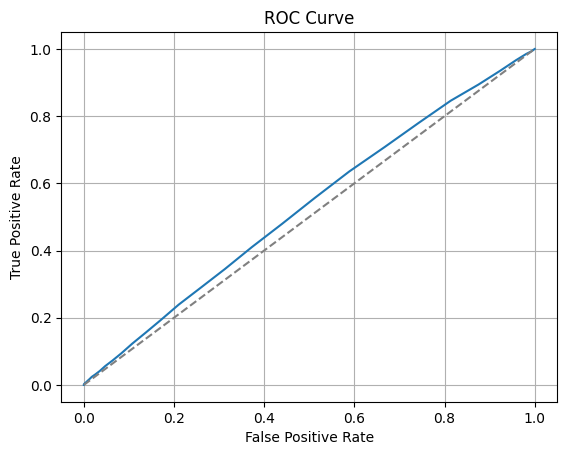

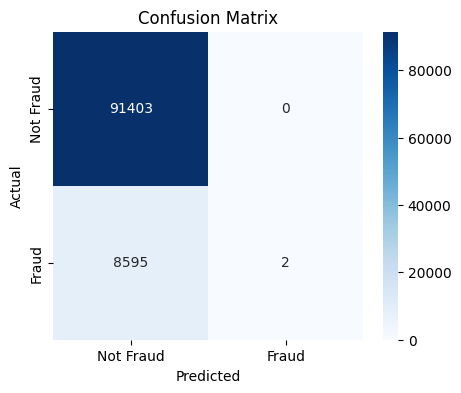

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96     91403
           1       1.00      0.00      0.00      8597

    accuracy                           0.91    100000
   macro avg       0.96      0.50      0.48    100000
weighted avg       0.92      0.91      0.87    100000

INTERSECTION


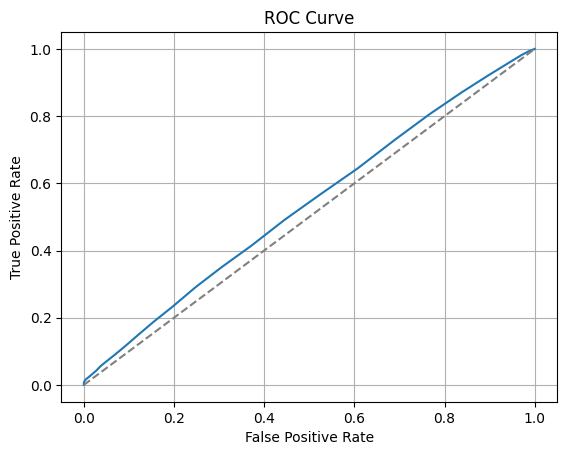

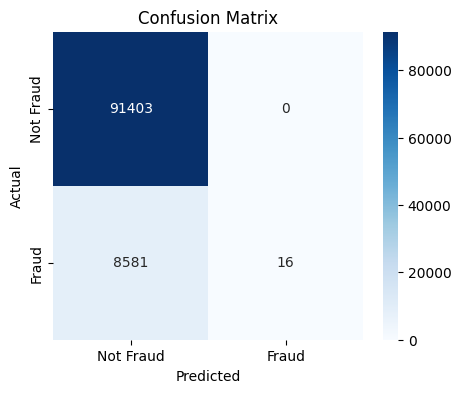

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96     91403
           1       1.00      0.00      0.00      8597

    accuracy                           0.91    100000
   macro avg       0.96      0.50      0.48    100000
weighted avg       0.92      0.91      0.87    100000


DecisionTreeClassifier
UNION


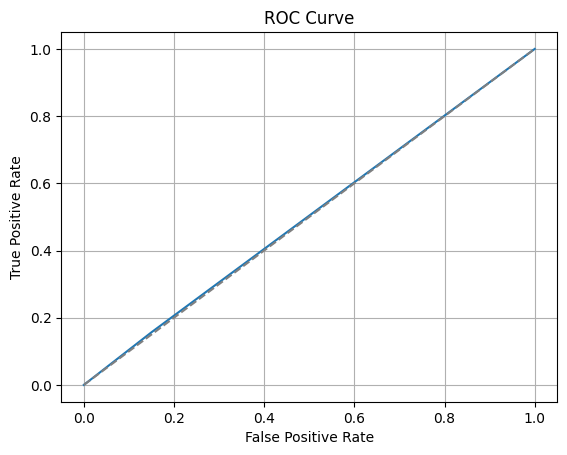

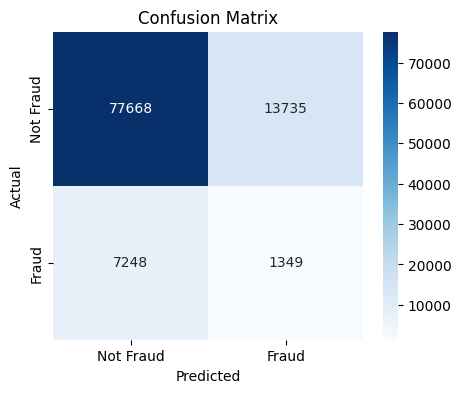

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88     91403
           1       0.09      0.16      0.11      8597

    accuracy                           0.79    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.84      0.79      0.82    100000

INTERSECTION


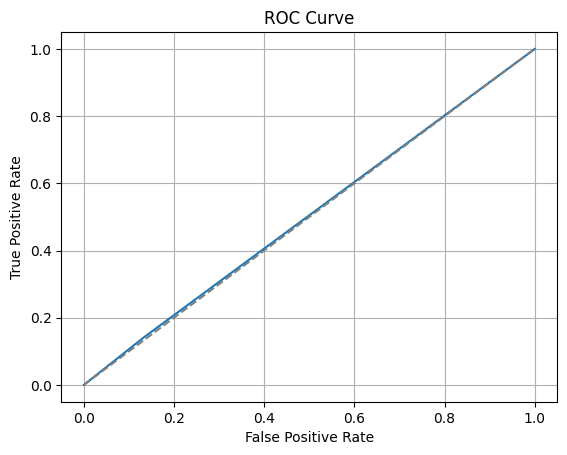

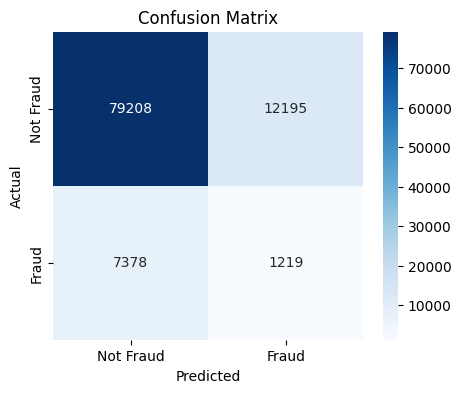

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     91403
           1       0.09      0.14      0.11      8597

    accuracy                           0.80    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.84      0.80      0.82    100000


XGBClassifier
UNION


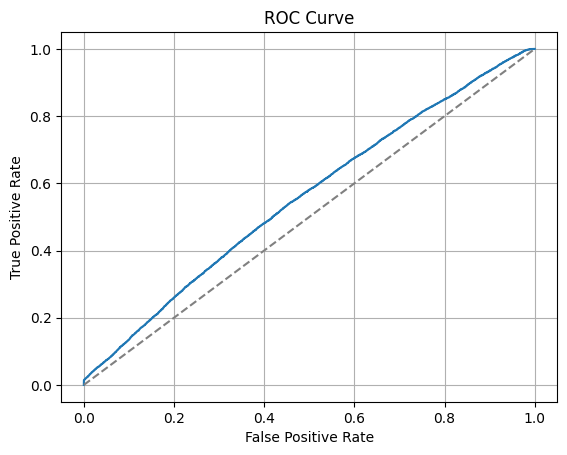

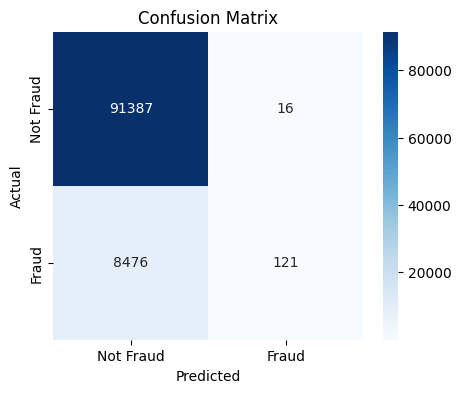

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     91403
           1       0.88      0.01      0.03      8597

    accuracy                           0.92    100000
   macro avg       0.90      0.51      0.49    100000
weighted avg       0.91      0.92      0.88    100000

INTERSECTION


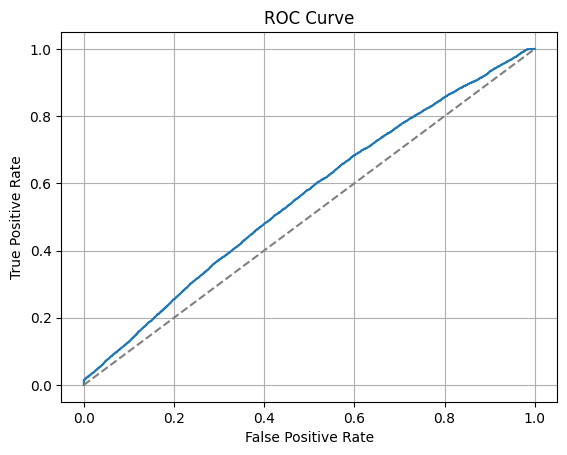

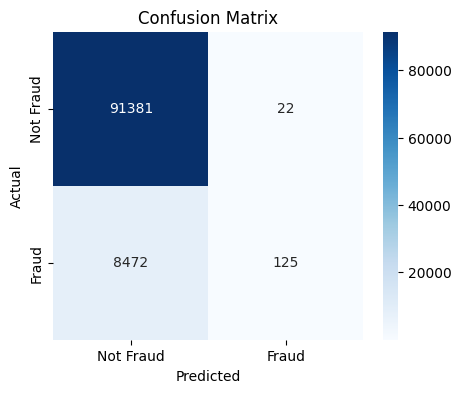

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     91403
           1       0.85      0.01      0.03      8597

    accuracy                           0.92    100000
   macro avg       0.88      0.51      0.49    100000
weighted avg       0.91      0.92      0.88    100000


LGBMClassifier
[LightGBM] [Info] Number of positive: 33814, number of negative: 366186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10076
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084535 -> initscore=-2.382266
[LightGBM] [Info] Start training from score -2.382266
UNION


/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


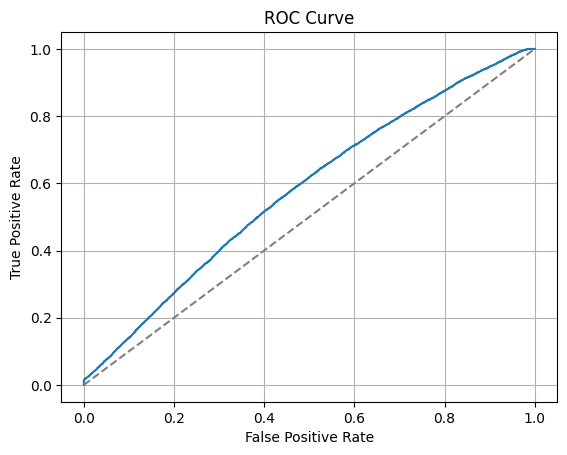

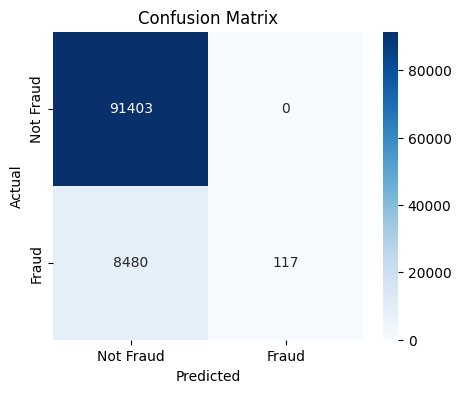

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     91403
           1       1.00      0.01      0.03      8597

    accuracy                           0.92    100000
   macro avg       0.96      0.51      0.49    100000
weighted avg       0.92      0.92      0.88    100000

[LightGBM] [Info] Number of positive: 33814, number of negative: 366186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3400
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084535 -> initscore=-2.382266
[LightGBM] [Info] Start training from score -2.382266
INTERSECTION


/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


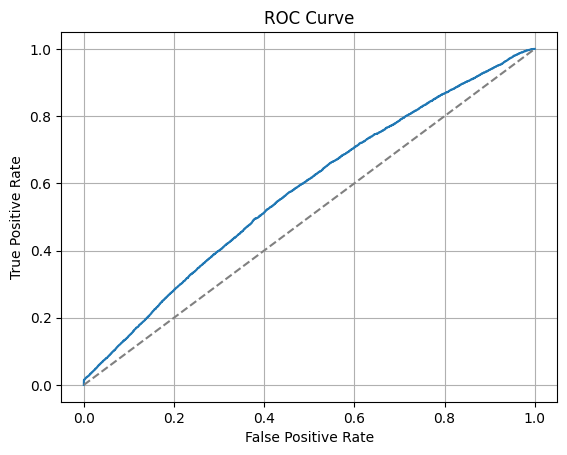

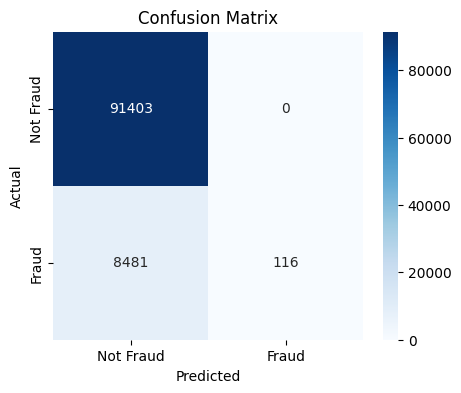

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     91403
           1       1.00      0.01      0.03      8597

    accuracy                           0.92    100000
   macro avg       0.96      0.51      0.49    100000
weighted avg       0.92      0.92      0.88    100000


LogisticRegression
UNION


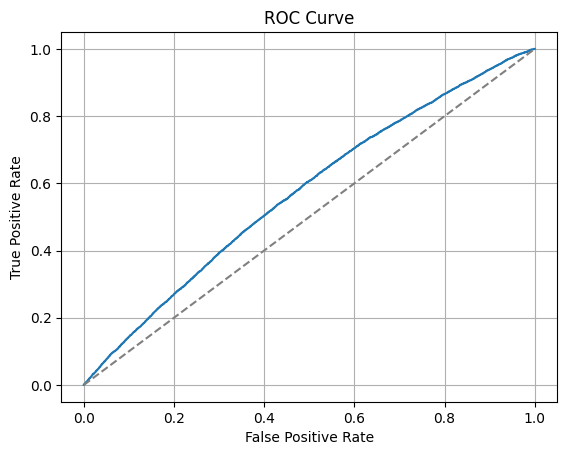

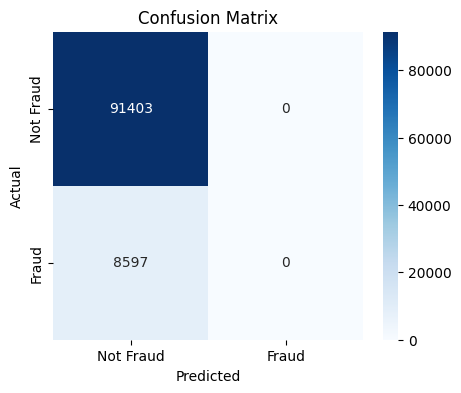

/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96     91403
           1       0.00      0.00      0.00      8597

    accuracy                           0.91    100000
   macro avg       0.46      0.50      0.48    100000
weighted avg       0.84      0.91      0.87    100000

INTERSECTION


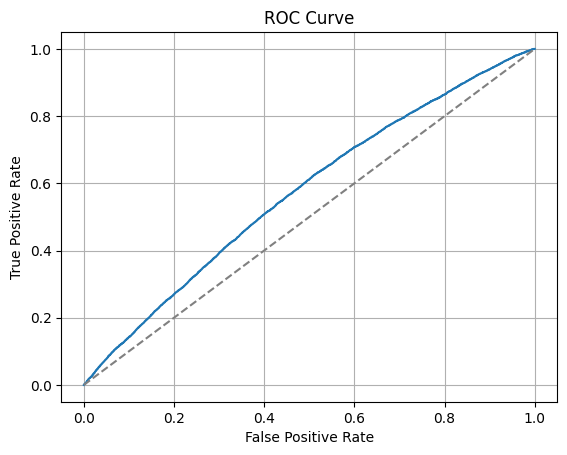

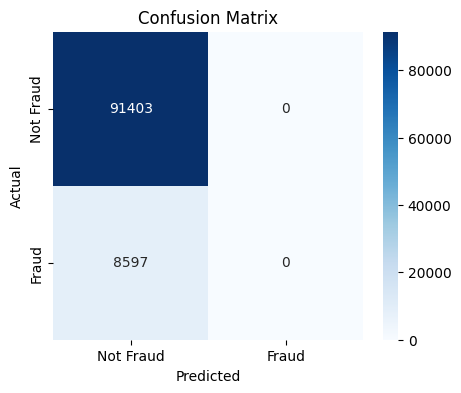

/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piotrkot/Programming/PycharmProjects/UNI/UczenieMaszynowe/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96     91403
           1       0.00      0.00      0.00      8597

    accuracy                           0.91    100000
   macro avg       0.46      0.50      0.48    100000
weighted avg       0.84      0.91      0.87    100000


GaussianNB
UNION


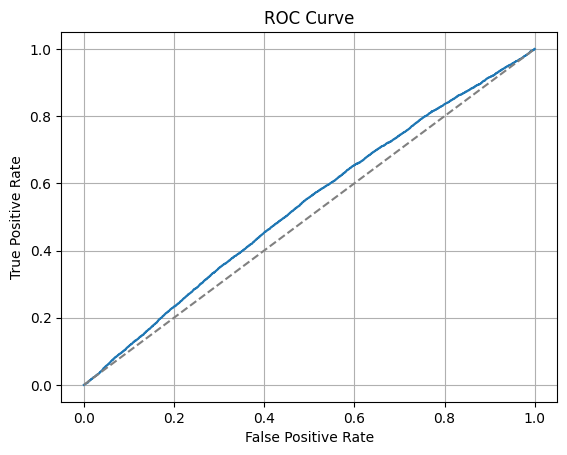

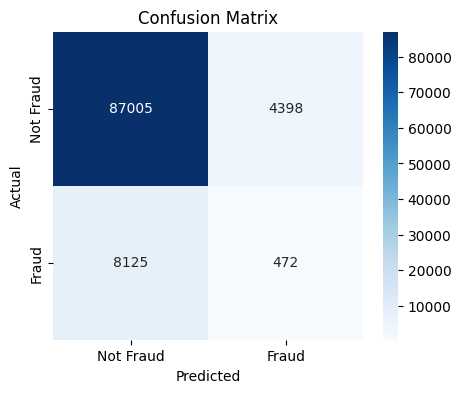

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     91403
           1       0.10      0.05      0.07      8597

    accuracy                           0.87    100000
   macro avg       0.51      0.50      0.50    100000
weighted avg       0.84      0.87      0.86    100000

INTERSECTION


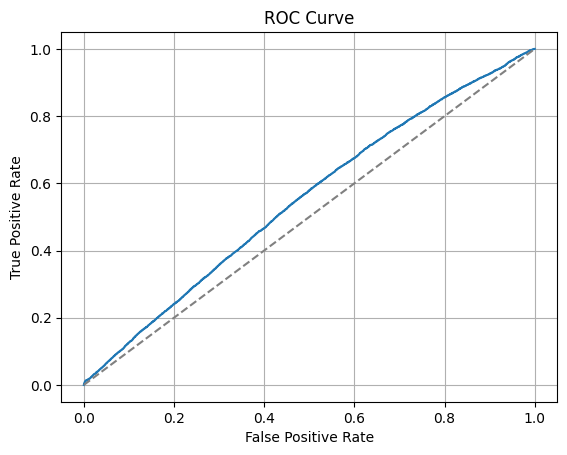

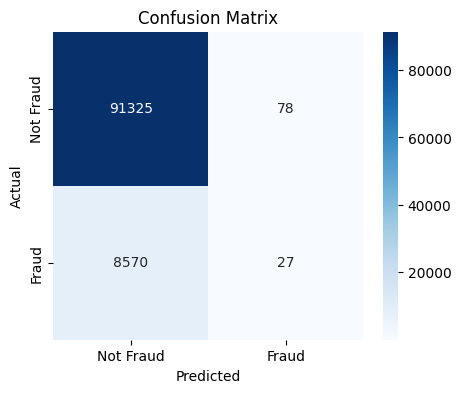

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     91403
           1       0.26      0.00      0.01      8597

    accuracy                           0.91    100000
   macro avg       0.59      0.50      0.48    100000
weighted avg       0.86      0.91      0.87    100000


AdaBoostClassifier
UNION


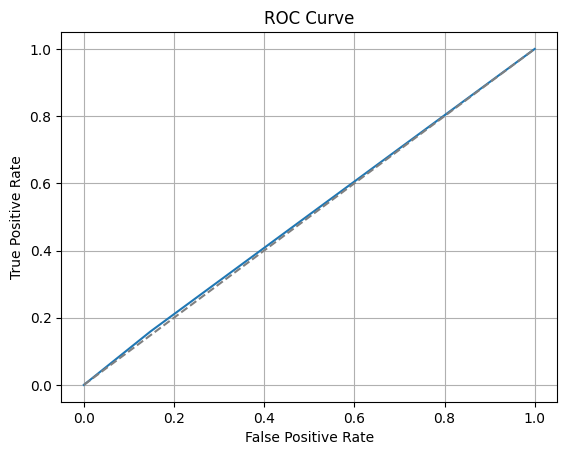

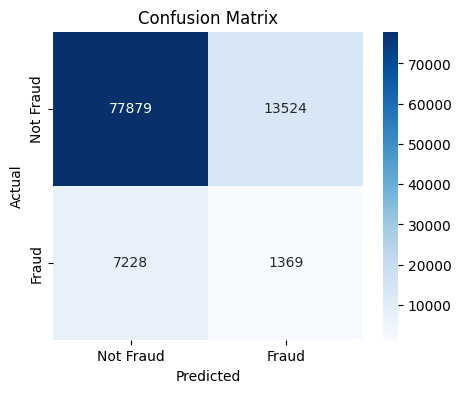

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88     91403
           1       0.09      0.16      0.12      8597

    accuracy                           0.79    100000
   macro avg       0.50      0.51      0.50    100000
weighted avg       0.84      0.79      0.82    100000

INTERSECTION


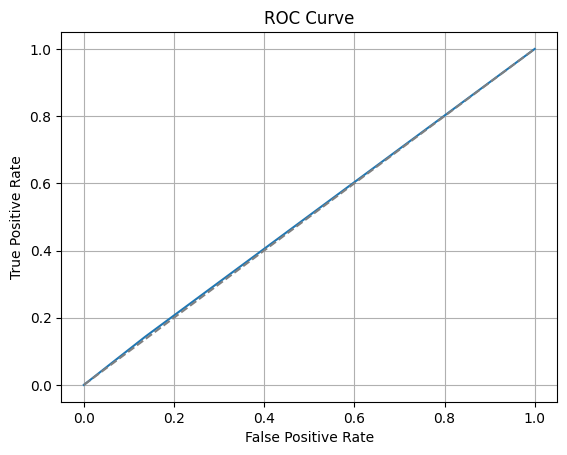

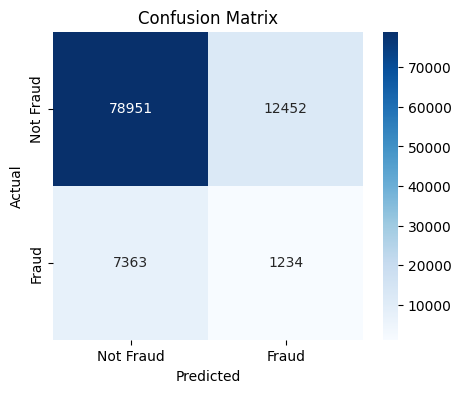

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89     91403
           1       0.09      0.14      0.11      8597

    accuracy                           0.80    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.84      0.80      0.82    100000



In [20]:
prod = TestingModels(union_indexes,intersection_indexes,X_train,y_train,X_test,y_test, ListofModels)

# GridSearch

In [24]:
f2_scorer = make_scorer(
    fbeta_score,
    beta=2,
    average='binary',   
    zero_division=0    
)

In [ ]:
X,_,y,_=train_test_split(X_train[:, intersection_indexes],y_train,stratify=y_train,test_size=0.5,random_state=42)

In [26]:
XgboostSearch(X,y,f2_scorer)
LightgbmSearch(X,y,f2_scorer)
AdaSearch(X,y,f2_scorer)
RFSearch(X,y,f2_scorer)
LogisticRegressionSearch(X,y,f2_scorer)
DecisionTreeSearch(X,y,f2_scorer)

LR start


KeyboardInterrupt: 